In [1]:
import kagglehub
import os
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.',msambare_fer2013_path)

msambare_fer2013_path

100%|██████████| 60.3M/60.3M [00:02<00:00, 30.6MB/s]

Extracting files...


Data source import complete. /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


'/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1'

In [17]:
pip install --ignore-installed blinker

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)


In [18]:
!pip install -r "/content/drive/MyDrive/Real-Time-Emotion-Recognition-and-AI-Mood-Uplifter/requir.txt"

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavan1304","key":"d9e8e0870a8c91925f9401ba972e06f7"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.69GB/s]


In [4]:
!unzip -q fer2013.zip -d /content/dataset/

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from google.colab.patches import cv2_imshow
import os


In [6]:
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/test'
# ===========================
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=30, zoom_range=0.3, width_shift_range=0.25, height_shift_range=0.25, shear_range=0.2, brightness_range=[0.6, 1.4], horizontal_flip=True, fill_mode='nearest' )
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( train_dir, target_size=(224, 224), batch_size=64, color_mode='rgb', class_mode='categorical' )
val_generator = val_datagen.flow_from_directory( val_dir, target_size=(224, 224), batch_size=64, color_mode='rgb', class_mode='categorical' )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Unfreeze the entire ResNet50 base for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
optimizer = Adam(learning_rate=1e-5)
model.compile( optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'] )
classes = list(train_generator.class_indices.keys())
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6), EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True), ModelCheckpoint('best_resnet50_emotion.keras', monitor='val_accuracy', save_best_only=True) ]
history = model.fit( train_generator, validation_data=val_generator, epochs=30, class_weight=class_weights, callbacks=callbacks )

{np.int32(0): np.float64(1.0266046844269623), np.int32(1): np.float64(9.406618610747051), np.int32(2): np.float64(1.0010460615781582), np.int32(3): np.float64(0.5684387684387684), np.int32(4): np.float64(0.8260394187886635), np.int32(5): np.float64(0.8491274770777877), np.int32(6): np.float64(1.293372978330405)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.1620 - loss: 2.4559 - val_accuracy: 0.1519 - val_loss: 2.7603 - learning_rate: 1.0000e-05
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.1889 - loss: 2.1072 - val_accuracy: 0.2031 - val_loss: 1.9746 - learning_rate: 1.0000e-05
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.2385 - loss: 1.9108 - val_accuracy: 0.3383 - val_loss: 1.6730 - learning_rate: 1.0000e-05
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.2863 - loss: 1.7992 - val_accuracy: 0.4076 - val_loss: 1.5467 - learning_rate: 1.0000e-05
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.3257 - loss: 1.7170 - val_accuracy: 0.4468 - val_loss: 1.4476 - learning_rate: 1.0000e-05
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.3754 - loss: 1.6037 - val_accuracy: 0.4863 - val_loss: 1.3800 - learning_rate: 1.0000e-05
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - acc

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import CategoricalCrossentropy
lr_schedule = CosineDecay(initial_learning_rate=1e-5, decay_steps=10000, alpha=1e-7)
model.compile( optimizer=Adam(1e-5), loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'] )
history_fine_tuned = model.fit( train_generator, validation_data=val_generator, epochs=30, class_weight=class_weights, callbacks=callbacks )
model.save('resnet50_fer2013_finetuned.keras')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title("Training and Validation Losses & Accuracies")
plt.show()

In [ ]:
history_df = pd.DataFrame(history_fine_tuned.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title("Training and Validation Losses & Accuracies with 20 epochs on lower learning rate")
plt.show()


In [21]:
import cv2 as cv
import mediapipe as mp
import time

class facereg:
    def __init__(self, minDetectioncon=0.5):
        self.minDetectioncon = minDetectioncon
        self.mp_face_detection = mp.solutions.face_detection
        self.mpdraw = mp.solutions.drawing_utils
        self.face_detection = self.mp_face_detection.FaceDetection(self.minDetectioncon)

    def detect_face(self, frame):
        imgRGB = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        self.results = self.face_detection.process(imgRGB)
        bbox = None
        if self.results.detections:
            for id, detect in enumerate(self.results.detections):
                bboxc = detect.location_data.relative_bounding_box
                ih, iw, ic = frame.shape
                bbox = int(bboxc.xmin * iw), int(bboxc.ymin * ih), \
                       int(bboxc.width * iw), int(bboxc.height * ih)
                cv.putText(frame, f'{int(detect.score[0]*100)} % ', (bbox[0],bbox[1]-20), cv.FONT_HERSHEY_PLAIN, 2, (0, 255, 120), 2)
        return frame, bbox

In [22]:

from tensorflow.keras.models import load_model


emotion_model = load_model('/content/resnet50_fer2013_finetuned.keras')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [26]:
def preprocess_face(frame, bbox):
    """Crop and preprocess face for model prediction."""
    x, y, w, h = bbox
    face = frame[y:y+h, x:x+w]
    if face.size == 0:
        return None
    face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
    face = cv.resize(face, (224, 224))   # ResNet50 input size
    face = np.expand_dims(face, axis=0)
    face = face / 255.0
    return face

In [12]:

detector = facereg(minDetectioncon=0.6)
cap = cv.VideoCapture()

pTime = 0
while True:
    success, frame = cap.read()
    if not success:
        break

    frame, bbox = detector.detect_face(frame)
    if bbox:
        face_input = preprocess_face(frame, bbox)
        if face_input is not None:
            preds = emotion_model.predict(face_input)
            emotion_idx = np.argmax(preds)
            confidence = np.max(preds)

            text = f"{emotion_labels[emotion_idx]} ({confidence*100:.1f}%)"
            x, y, w, h = bbox
            cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv.putText(frame, text, (x, y-10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # show FPS
    cTime = time.time()
    fps = 1 / (cTime - pTime) if pTime != 0 else 0
    pTime = cTime
    cv.putText(frame, f'FPS: {int(fps)}', (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    cv.imshow('Emotion Recognition', frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

NameError: name 'mp' is not defined

In [24]:
from openai import OpenAI
from google.colab import userdata
client = OpenAI(api_key=userdata.get('Openai'))

def generate_mood_message(emotion_label):
    """Generate motivational message using GPT."""
    prompt = f"Write one short uplifting message for someone who is {emotion_label.lower()}. Keep it under 10 words."
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("GPT Error:", e)
        return "Stay positive and strong!"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


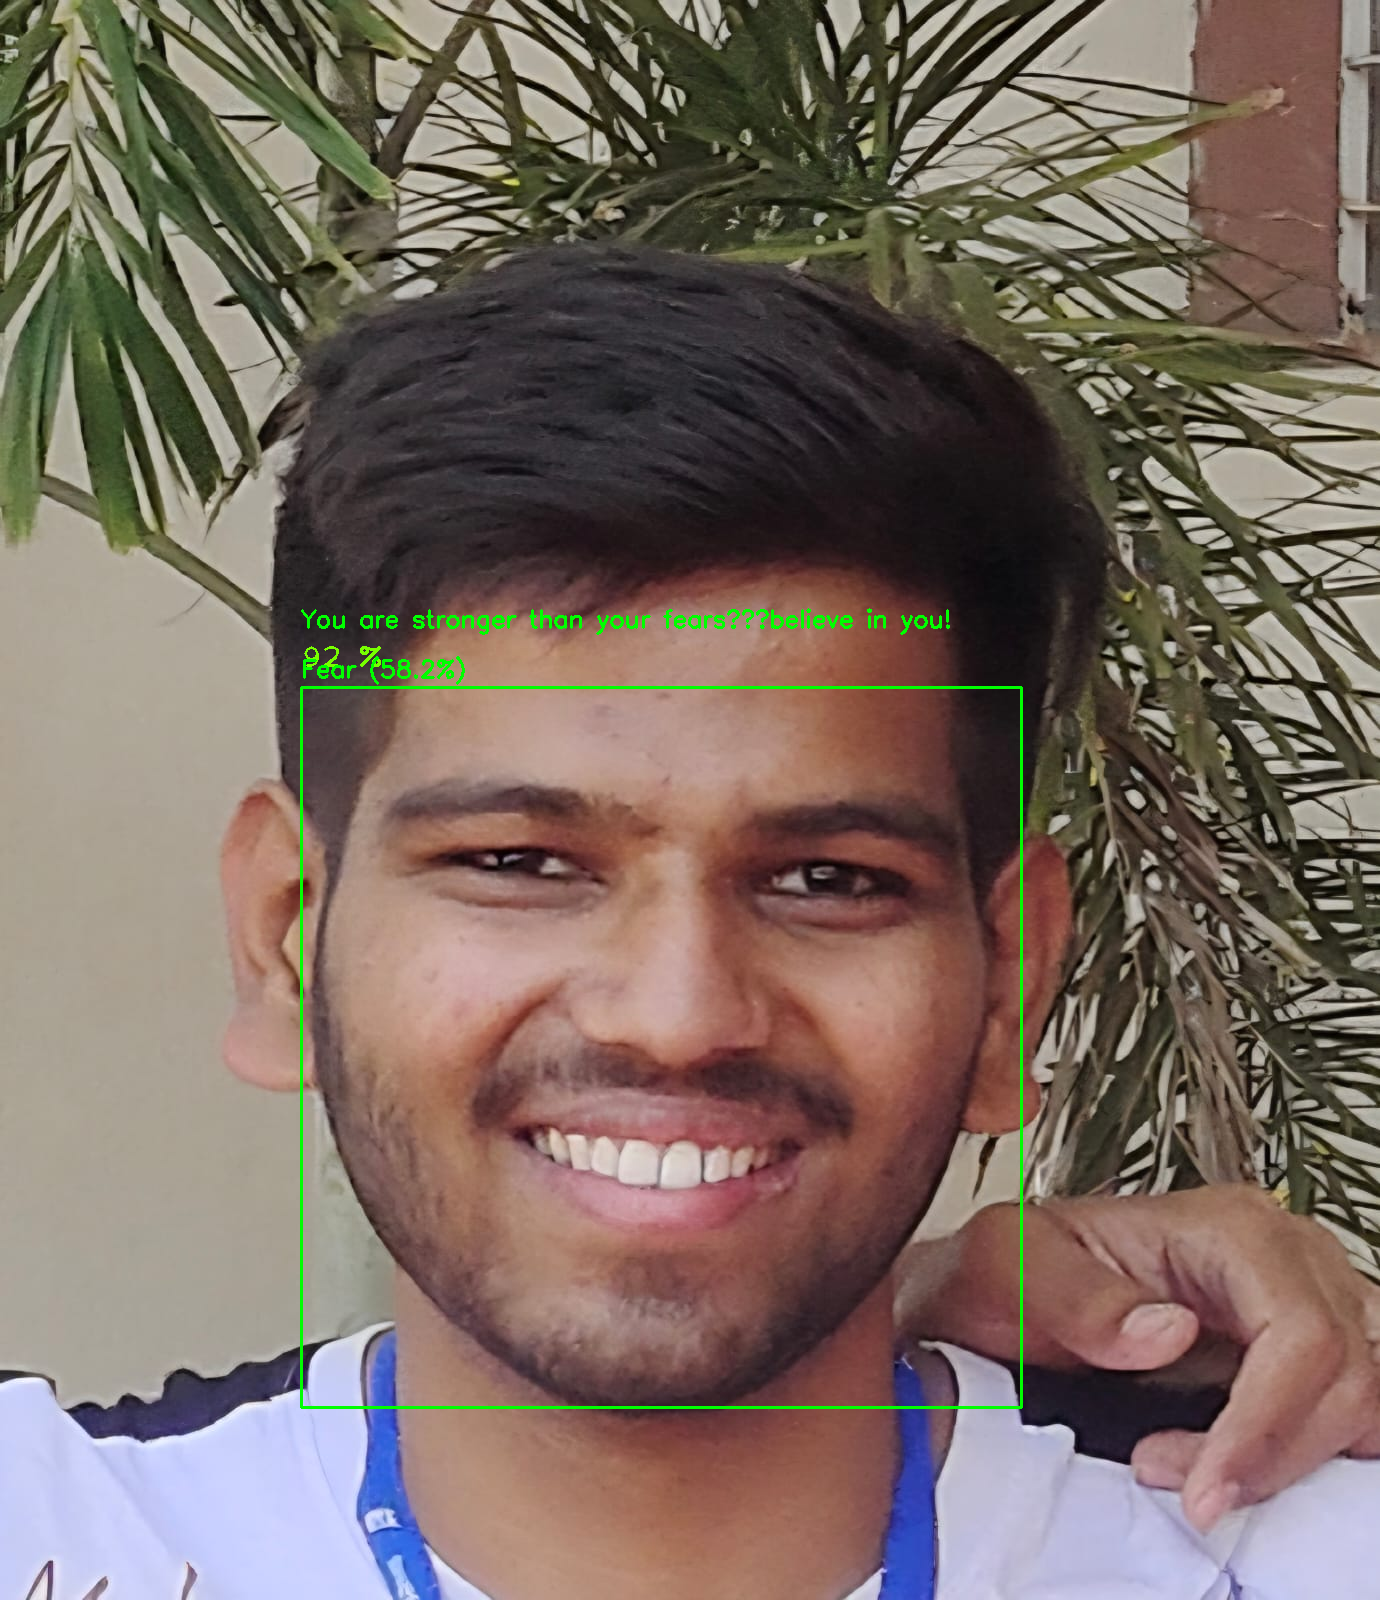

You are stronger than your fears—believe in you!


In [28]:
img = cv.imread('/content/drive/MyDrive/Img_Read/Testing_face/WhatsApp Image 2025-09-24 at 17.07.21_c694cb67.jpg')

# Initialize face detector
detector = facereg(minDetectioncon=0.6)

# Detect face and bounding box
frame, bbox = detector.detect_face(img)
face_input = preprocess_face(frame, bbox)

if face_input is not None:
    preds = emotion_model.predict(face_input)
    emotion_idx = np.argmax(preds)
    confidence = np.max(preds)
    emotion_message=generate_mood_message(emotion_labels[emotion_idx])
    text = f"{emotion_labels[emotion_idx]} ({confidence*100:.1f}%)"

    x, y, w, h = bbox
    cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv.putText(frame, text, (x, y-10),
               cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv.putText(frame, emotion_message, (x, y-60),
               cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

else:
    cv.putText(frame, "No face detected", (30, 50),
               cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

cv2_imshow(frame)
cv.waitKey(0)
cv.destroyAllWindows()
print(emotion_message)